In [2]:
# Load preprocessed data
import pandas as pd
df = pd.read_csv("cbis-ddsm-breast-cancer-image-dataset/csv/combined_cleaned.csv")

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

### CLAHE Processing

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

IMG_SIZE = 224
# CLAHE preprocessing, normalising and greyscaling
def load_and_preprocess(path):
    try:
        # Read as grayscale
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Apply CLAHE (clipLimit ~2.0, tileGridSize ~8x8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)

        # Resize to target size
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

        # Normalize to [0,1]
        img = img.astype("float32") / 255.0

        # Add channel dimension for later concatenation
        return img[..., None]
    except:
        return None


In [5]:
# Merging the 3 images (full, cropped, roi)
images = []
labels = []

for _, row in df.iterrows():
    full = load_and_preprocess(row['image file path'])
    crop = load_and_preprocess(row['cropped image file path'])
    roi  = load_and_preprocess(row['ROI mask file path'])

    if all(x is not None for x in (full, crop, roi)):
        combined = np.concatenate([full, crop, roi], axis=-1)
        images.append(combined)
        labels.append(row['label'])


X = np.array(images)
y = np.array(labels)

### CLAHE Vs Original Image

Original image shape: (5176, 3061)
Processed image shape: (224, 224)


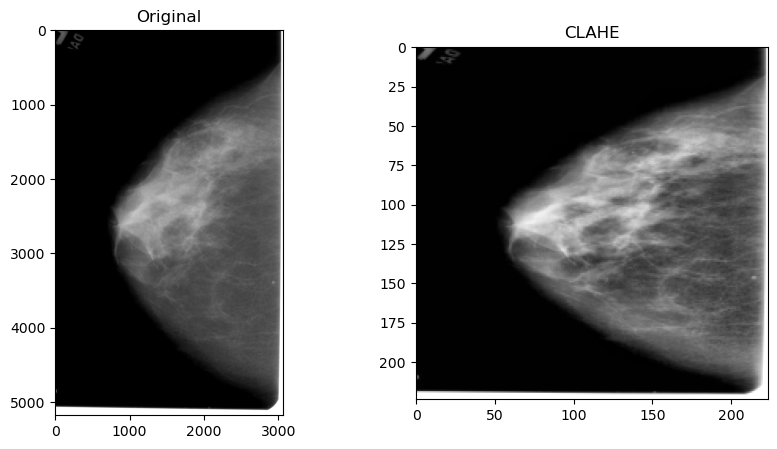

In [7]:
# Show CLAHE vs Original Image
# Get the first image path and check if it exists
path = df.iloc[0]['image file path']

# Check if the file exists
import os
if not os.path.exists(path):
    for i in range(len(df)):
        test_path = df.iloc[i]['image file path']
        if os.path.exists(test_path):
            path = test_path
            break
    else:
        exit()

# Load the original image
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
if img is None:
    exit()

# Apply preprocessing
clahe_img = load_and_preprocess(path)
if clahe_img is None:
    exit()

# Remove channel dimension for display
clahe_img = clahe_img.squeeze()

print(f"Original image shape: {img.shape}")
print(f"Processed image shape: {clahe_img.shape}")

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(clahe_img, cmap='gray'); plt.title("CLAHE")

plt.show()



In [6]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Data augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal"), 
    layers.RandomRotation(factor=0.05),  # ~ +-9 degrees
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
    # NO brightness/contrast/color jitter since one channel is an ROI mask
], name="augmentation")

### FTS Implementation instead of Relu Activation
Flattened Threshold Switch (FTS), was a novel activation function used to preserve miniority-class features. FTS behaves similar to a sigmoid-activation function, but has a constant output Thr, that prevents miniority class features from being zeroed (ReLu). It should have a slightly higher recall than normal Relu functions, with the trade-off of slightly lower precision and accuracy.

In [ ]:
### FTS Implementation
# Following the formula in case study 4
from tensorflow.keras import backend as K

# Custom FTS activation
def FTS(x, Thr=0.1):
    return tf.where(x >= 0, (x / (1 + tf.exp(-x))) + Thr, tf.fill(tf.shape(x), Thr))

# Wrap it for use in Keras layers
from tensorflow.keras.layers import Activation
FTS_activation = Activation(FTS)


In [10]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

IMG_SIZE = 224

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Data augmentation
x = data_augmentation(inputs)

# Stage 1
x = layers.Conv2D(16, (3,3), strides=1, padding="same")(x)
x = FTS_activation(x)
x = layers.MaxPooling2D((2,2))(x)

# Stage 2
x = layers.Conv2D(32, (3,3), padding="same")(x)
x = FTS_activation(x)
x = layers.MaxPooling2D((2,2))(x)

# Stage 3
x = layers.Conv2D(64, (3,3), padding="same")(x)
x = FTS_activation(x)
x = layers.MaxPooling2D((2,2))(x)

# Stage 4: Residual block
res = layers.Conv2D(64, (1,1), padding="same")(x)
res = FTS_activation(res)
res = layers.Conv2D(64, (3,3), padding="same")(res)
res = FTS_activation(res)
res = layers.Conv2D(64, (1,1), padding="same")(res)
res = FTS_activation(res)

x = layers.Add()([x, res])

# Global pooling + output
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Build model
fts_model = Model(inputs, outputs)
fts_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ augmentation[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ conv2d[0][0],     │
│ (Activation)        │ 64)               │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_1[1][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ activation_1[2][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      4,160 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     36,928 │ activation_1[3][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      4,160 │ activation_1[4][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │ activation_1[5][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 68,897 (269.13 KB)

 Trainable params: 68,897 (269.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

fts_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3,
    verbose=1,
    min_lr=1e-6 
)

# Define a callback
monitor_val_loss = EarlyStopping(monitor='val_loss', 
                       patience=5, restore_best_weights=True)

fts_history = fts_model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[monitor_val_loss, reduce_lr])

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.5795 - loss: 0.6795 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5901 - val_loss: 0.6761 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - accuracy: 0.5918 - loss: 0.6754 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5901 - val_loss: 0.6756 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 392ms/step - accuracy: 0.5912 - loss: 0.6749 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5901 - val_loss: 0.6751 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - accuracy: 0.5935 - loss: 0.6739 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5901 - val_loss: 0.6749 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learni

In [13]:
fts_model.evaluate(X_val, y_val)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6337 - loss: 0.6416 - precision: 0.6121 - recall: 0.2990


[0.6279383897781372,
 0.6471494436264038,
 0.6370370388031006,
 0.3233082592487335]

#### Plotting function

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

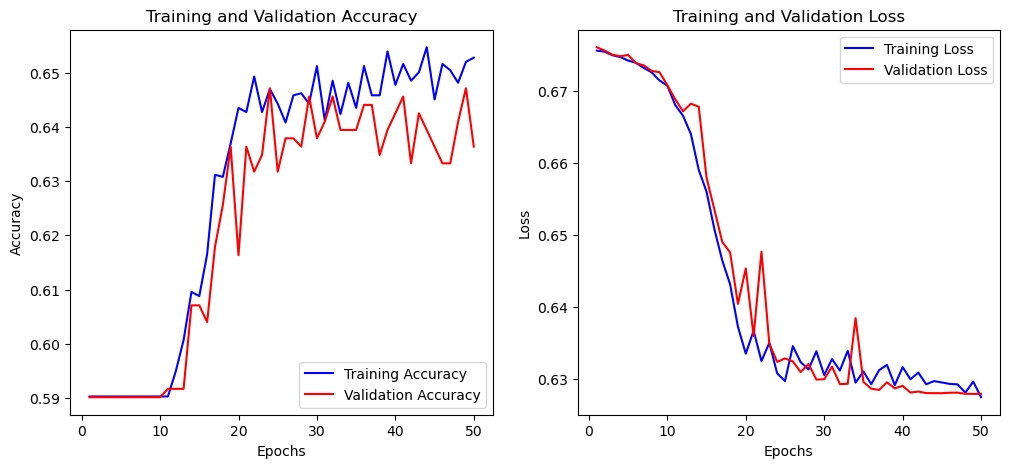

In [ ]:
plot_training_history(fts_history)

#### Custom Model Implementation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

x = Sequential()

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Data augmentation block 
x = data_augmentation(inputs)

# Stage 1
x = layers.Conv2D(16, (3,3), strides=1, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)

# Stage 2
x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)

# Stage 3
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)

# Stage 4: residual block (1x1 -> 3x3 -> 1x1)
res = layers.Conv2D(64, (1,1), padding="same", activation="relu")(x)
res = layers.Conv2D(64, (3,3), padding="same", activation="relu")(res)
res = layers.Conv2D(64, (1,1), padding="same", activation="relu")(res)
x = layers.Add()([x, res])

# Global Average Pooling + output
x = layers.GlobalAveragePooling2D()(x)

# Labels are already binary 
outputs = layers.Dense(1, activation="sigmoid")(x)


model = Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ augmentation[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      4,160 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      4,160 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 68,897 (269.13 KB)

 Trainable params: 68,897 (269.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3,
    verbose=1,
    min_lr=1e-6 
)

# Define a callback
monitor_val_loss = EarlyStopping(monitor='val_loss', 
                       patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[monitor_val_loss, reduce_lr])


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - accuracy: 0.5943 - loss: 0.6806 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5901 - val_loss: 0.6779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.5932 - loss: 0.6783 - precision: 0.8111 - recall: 0.0048 - val_accuracy: 0.6025 - val_loss: 0.6702 - val_precision: 0.7857 - val_recall: 0.0414 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.6086 - loss: 0.6697 - precision: 0.7478 - recall: 0.0818 - val_accuracy: 0.6225 - val_loss: 0.6564 - val_precision: 0.8387 - val_recall: 0.0977 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.6290 - loss: 0.6579 - precision: 0.7202 - recall: 0.1367 - val_accuracy: 0.6348 - val_loss: 0.6513 - val_precision: 0.8372 - val_recall: 0.1353 - learning_rate: 1.0000e-04
Epoch 5/50
81/81 ━━━━━━━━━━━

In [11]:
model.evaluate(X_val, y_val)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6224 - loss: 0.6373 - precision: 0.5862 - recall: 0.2725


[0.6306470036506653,
 0.6425269842147827,
 0.6349206566810608,
 0.30075186491012573]

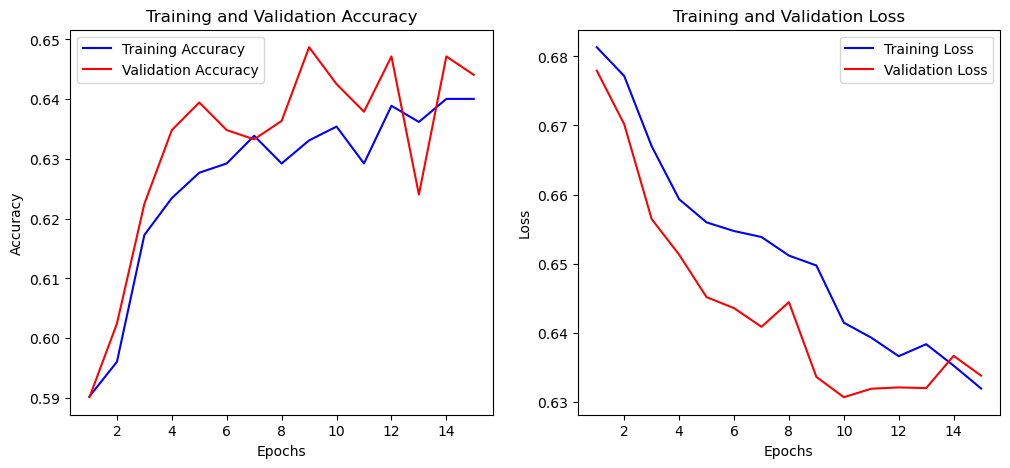

In [ ]:

plot_training_history(history)


    ### Validation Accuracy = 0.643, Precision = 0.634, Recall = 0.300

### GRAD CAM Visualisation

In [ ]:
# GRAD-CAM Implementation
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

class GradCAM:
    def __init__(self, model, layer_name=None):
        # Initialize a GRAD-CAM model
        
        self.model = model
        self.layer_name = layer_name
        
        # Auto-detect the last convolutional layer if not specified
        if self.layer_name is None:
            for layer in reversed(self.model.layers):
                if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Conv2DTranspose)):
                    self.layer_name = layer.name
                    break
        
        print(f"Using layer: {self.layer_name}")
        
        # Create a model that outputs the feature maps and the prediction
        self.grad_model = tf.keras.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layer_name).output, self.model.output]
        )
    
    def compute_gradcam(self, image, class_idx=None, eps=1e-8):

        # Get the gradients of the class output with respect to the feature maps
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (conv_outputs, predictions) = self.grad_model(inputs)
            
            if class_idx is None:
                class_idx = tf.argmax(predictions[0])
            
            loss = predictions[:, class_idx]
        
        # Compute gradients
        grads = tape.gradient(loss, conv_outputs)
        
        # Global average pooling of gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Get the feature maps
        conv_outputs = conv_outputs[0]
        
        # Multiply each feature map by its corresponding gradient
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        # Normalize the heatmap
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        return heatmap.numpy()
        
    # Overlay heatmap on the original image
    def overlay_heatmap(self, heatmap, image, alpha=0.4):

        # Resize heatmap to match image size
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        
        # Convert heatmap to RGB
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        # Convert image to RGB if it's grayscale
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Ensure both images are uint8
        image = np.uint8(255 * image) if image.max() <= 1.0 else image.astype(np.uint8)
        
        # Overlay heatmap on image
        overlayed = cv2.addWeighted(image, 1-alpha, heatmap, alpha, 0)
        
        return overlayed

def visualize_gradcam(gradcam, image, heatmap, overlayed, prediction, class_names=['Benign', 'Malignant']):

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original image (first channel - full mammogram)
    axes[0].imshow(image[0, :, :, 0], cmap='gray')
    axes[0].set_title('Original Image (Full)')
    axes[0].axis('off')
    
    # Cropped image (second channel)
    axes[1].imshow(image[0, :, :, 1], cmap='gray')
    axes[1].set_title('Cropped Image')
    axes[1].axis('off')
    
    # GRAD-CAM heatmap
    im = axes[2].imshow(heatmap, cmap='jet')
    axes[2].set_title('GRAD-CAM Heatmap')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    # Overlay
    axes[3].imshow(overlayed)
    axes[3].set_title(f'Overlay\nPrediction: {class_names[int(prediction > 0.5)]} ({prediction:.3f})')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Initialize GRAD-CAM for our model
gradcam = GradCAM(model)



Using layer: conv2d_5


Running comprehensive GRAD-CAM analysis...
Validation Set Analysis:
Total samples: 649
Correct predictions: 417
Incorrect predictions: 232
Accuracy: 0.643

=== CORRECT PREDICTIONS ===

--- Correct Prediction 1 (Index 621) ---
True: Benign
Predicted: Benign (0.4877)


c:\Users\rando\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


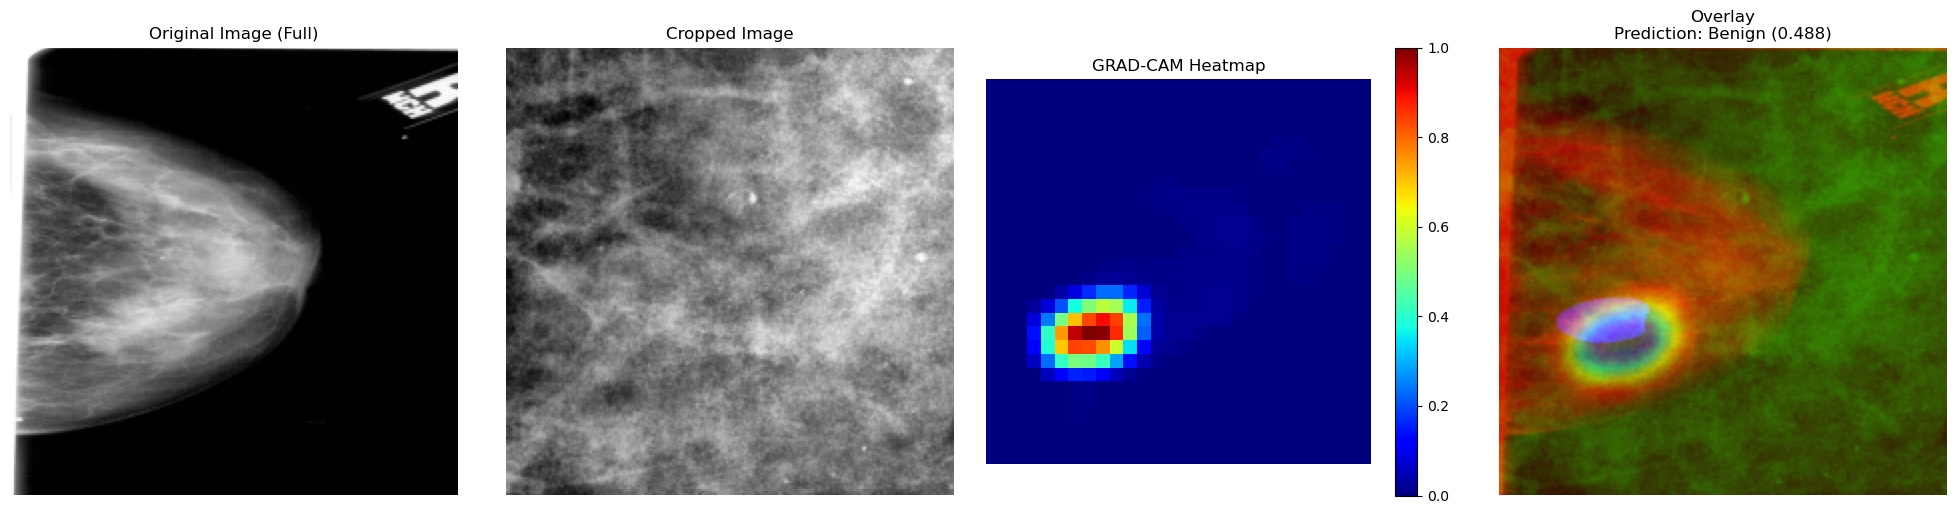


--- Correct Prediction 2 (Index 638) ---
True: Benign
Predicted: Benign (0.2805)


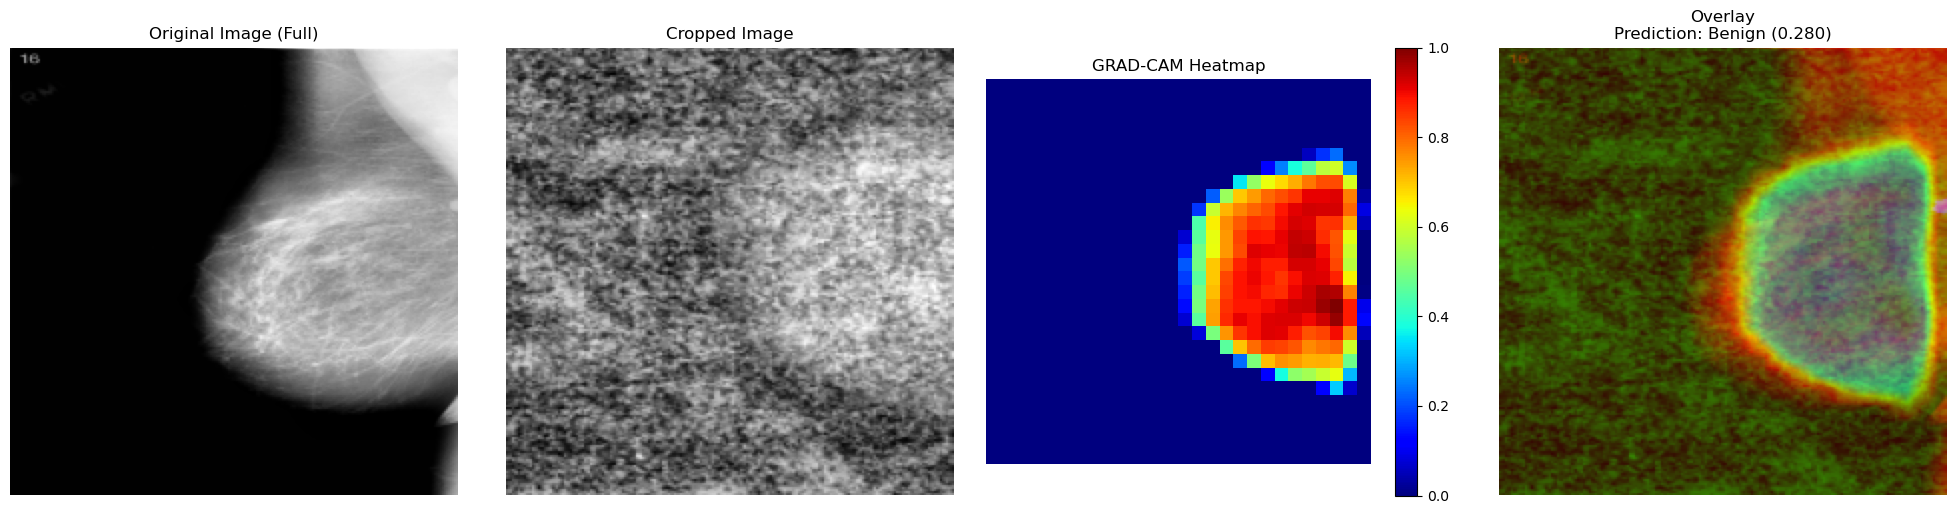


--- Correct Prediction 3 (Index 565) ---
True: Malignant
Predicted: Malignant (0.5478)


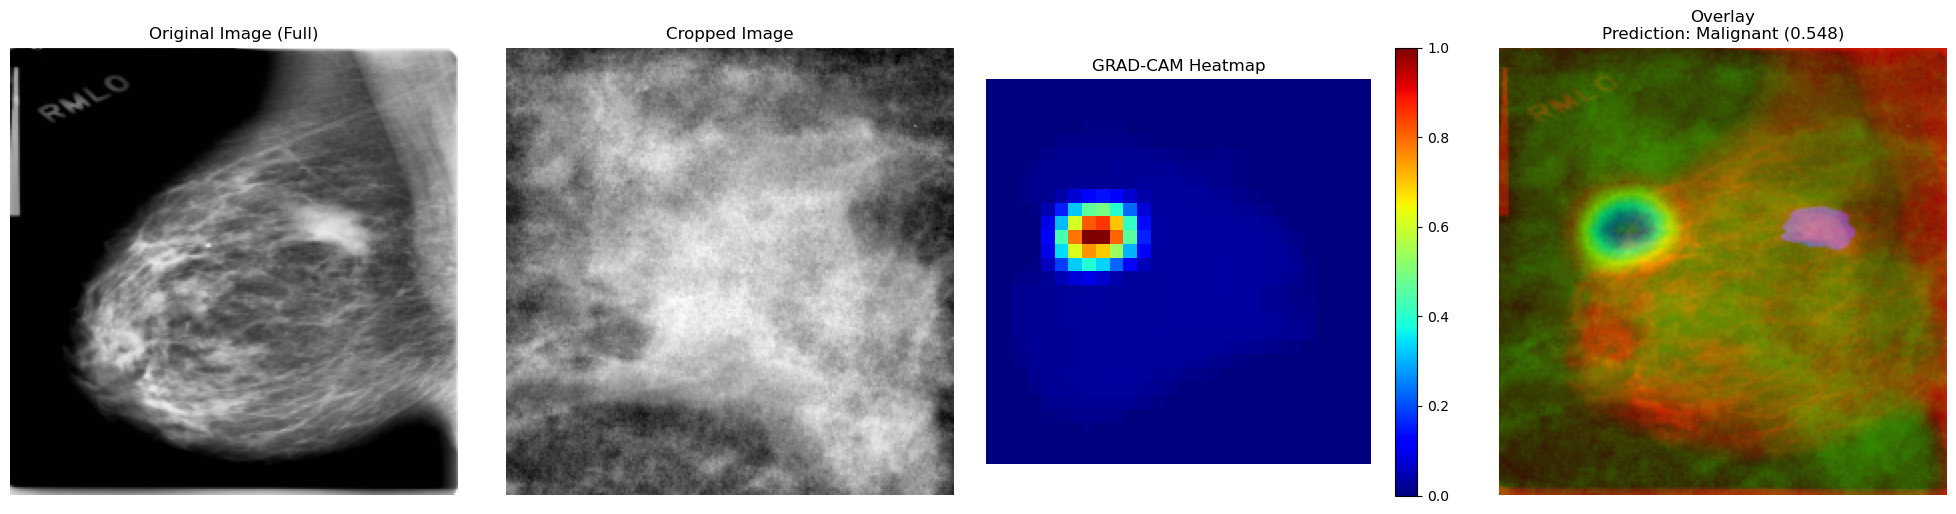


=== INCORRECT PREDICTIONS ===

--- Incorrect Prediction 1 (Index 239) ---
True: Malignant
Predicted: Benign (0.4451)


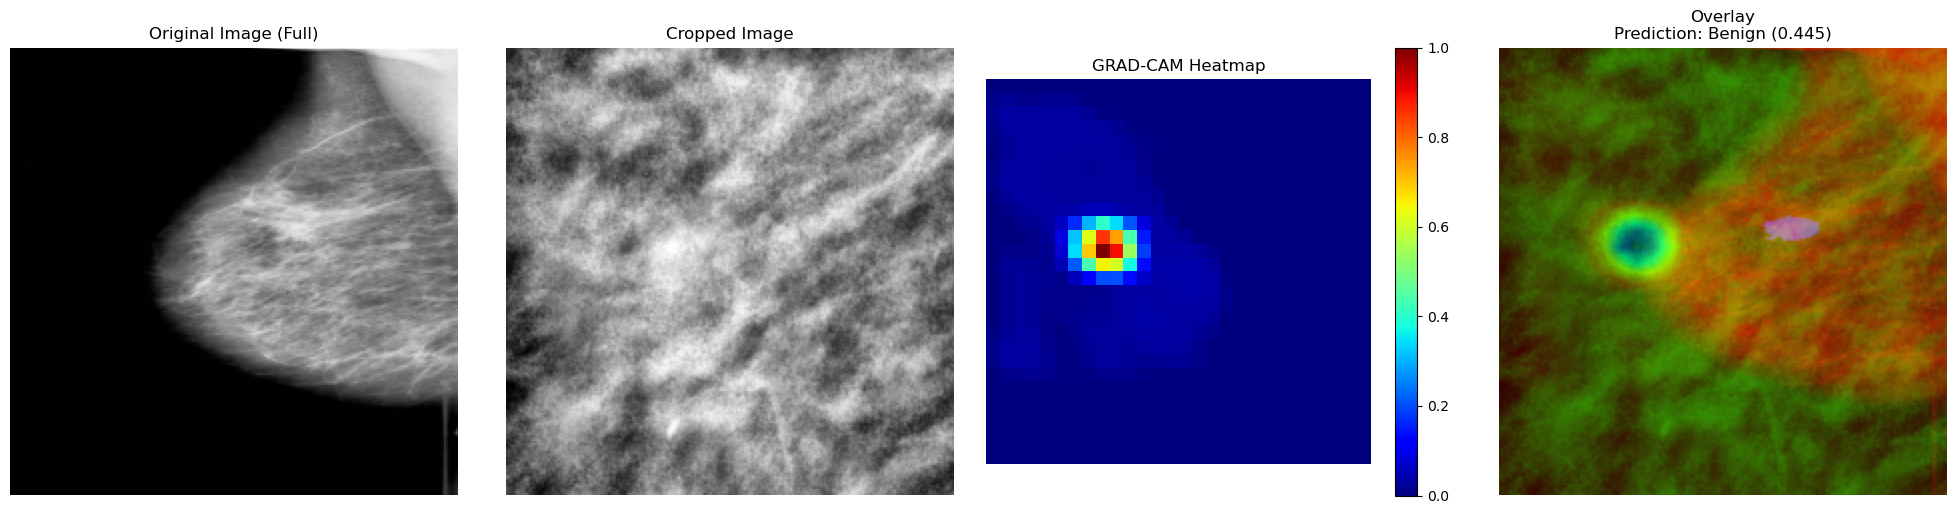


--- Incorrect Prediction 2 (Index 513) ---
True: Malignant
Predicted: Benign (0.3202)


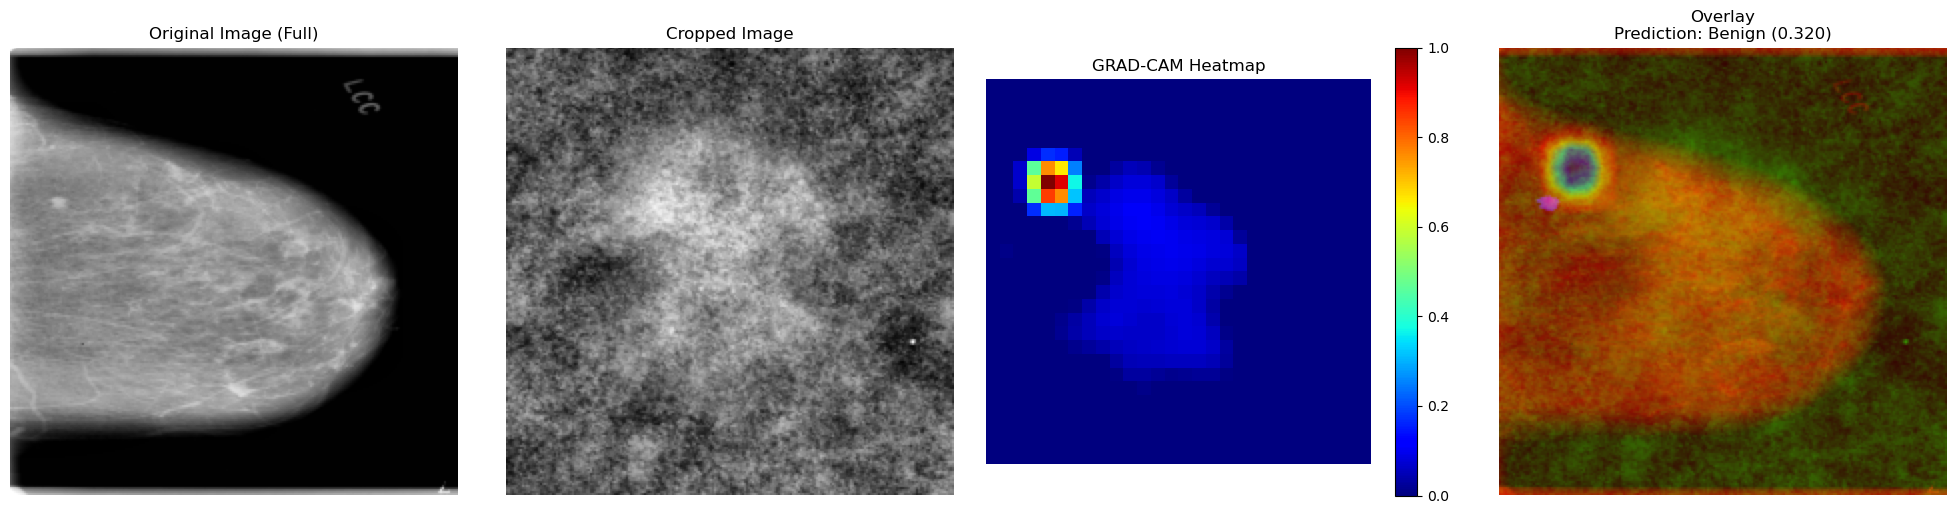


--- Incorrect Prediction 3 (Index 369) ---
True: Malignant
Predicted: Benign (0.4121)


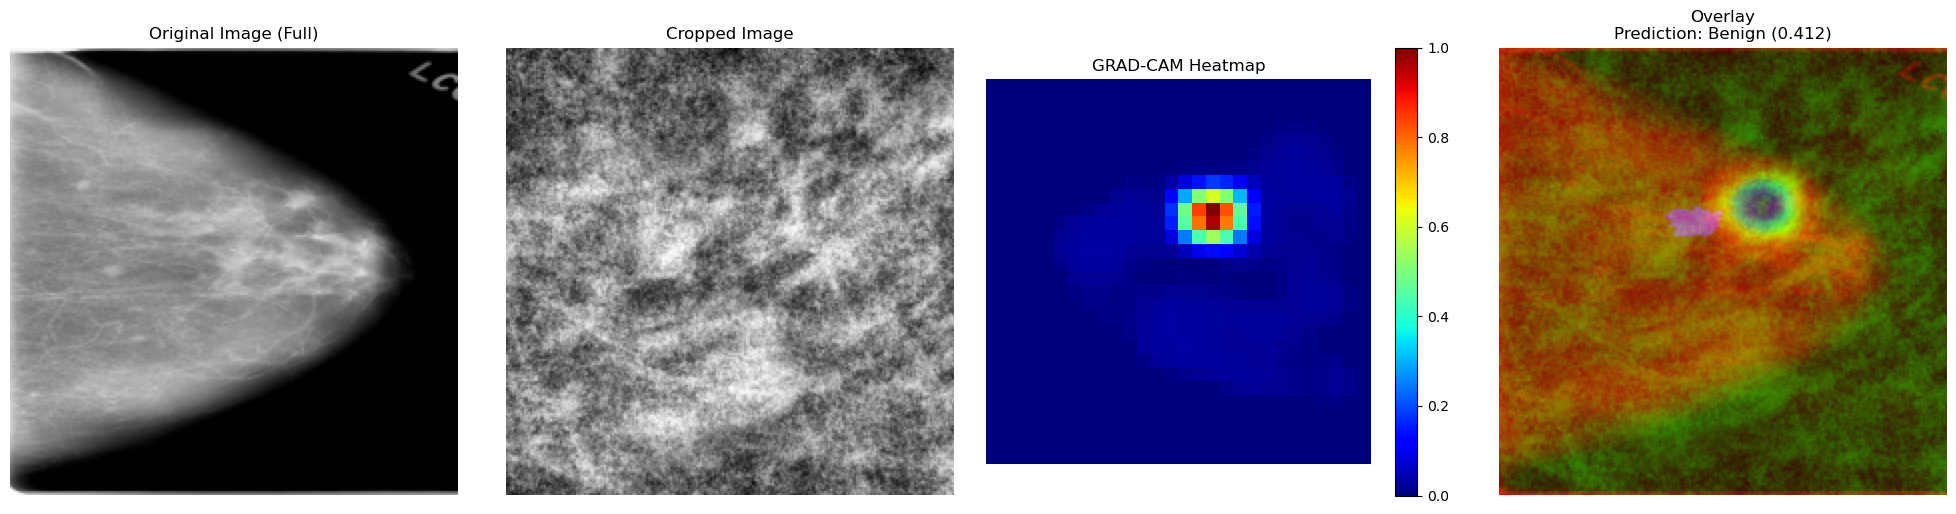

In [ ]:
# GRAD CAM Visualisation
# Analyse incorrect and correct predictions

def analyze_model_GRAD_CAM(model, X_val, y_val, num_cases=5):

    # Get predictions for all validation samples
    predictions = model.predict(X_val, verbose=0)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    
    # Find correct and incorrect predictions
    correct_indices = np.where(predicted_classes == y_val)[0]
    incorrect_indices = np.where(predicted_classes != y_val)[0]
    
    print(f"Validation Set Analysis:")
    print(f"Total samples: {len(X_val)}")
    print(f"Correct predictions: {len(correct_indices)}")
    print(f"Incorrect predictions: {len(incorrect_indices)}")
    print(f"Accuracy: {len(correct_indices)/len(X_val):.3f}")
    
    # Analyze correct predictions
    if len(correct_indices) > 0:
        print(f"\n=== CORRECT PREDICTIONS ===")
        correct_samples = np.random.choice(correct_indices, 
                                         min(num_cases, len(correct_indices)), 
                                         replace=False)
        
        for i, idx in enumerate(correct_samples):
            print(f"\n--- Correct Prediction {i+1} (Index {idx}) ---")
            image = X_val[idx:idx+1]
            true_label = y_val[idx]
            prediction = predictions[idx][0]
            
            print(f"True: {'Malignant' if true_label == 1 else 'Benign'}")
            print(f"Predicted: {'Malignant' if prediction > 0.5 else 'Benign'} ({prediction:.4f})")
            
            # Compute GRAD-CAM
            heatmap = gradcam.compute_gradcam(image)
            overlayed = gradcam.overlay_heatmap(heatmap, image[0])
            visualize_gradcam(gradcam, image, heatmap, overlayed, prediction)
    
    # Analyze incorrect predictions
    if len(incorrect_indices) > 0:
        print(f"\n=== INCORRECT PREDICTIONS ===")
        incorrect_samples = np.random.choice(incorrect_indices, 
                                           min(num_cases, len(incorrect_indices)), 
                                           replace=False)
        
        for i, idx in enumerate(incorrect_samples):
            print(f"\n--- Incorrect Prediction {i+1} (Index {idx}) ---")
            image = X_val[idx:idx+1]
            true_label = y_val[idx]
            prediction = predictions[idx][0]
            
            print(f"True: {'Malignant' if true_label == 1 else 'Benign'}")
            print(f"Predicted: {'Malignant' if prediction > 0.5 else 'Benign'} ({prediction:.4f})")
            
            # Compute GRAD-CAM
            heatmap = gradcam.compute_gradcam(image)
            overlayed = gradcam.overlay_heatmap(heatmap, image[0])
            visualize_gradcam(gradcam, image, heatmap, overlayed, prediction)


# Run comprehensive analysis
print("Running comprehensive GRAD-CAM analysis...")
analyze_model_GRAD_CAM(model, X_val, y_val, num_cases=3)


### Comprehensive study of Transfer Learning

#### Fine Tuning (using VGG16-10)

In [ ]:
# VGG16 Transfer Learning + Fine-Tuning (VGG16-10-FT)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Prepare inputs for VGG16 preprocessing
def to_vgg_inputs(x: np.ndarray) -> np.ndarray:
    x255 = (x * 255.0).astype("float32")
    return preprocess_input(x255)

X_train_vgg = to_vgg_inputs(X_train)
X_val_vgg = to_vgg_inputs(X_val)

# Build VGG16 base
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Fine-tune from layer index 10 onward
for idx, layer in enumerate(base_model.layers):
    layer.trainable = (idx >= 10)

# Head for binary classification
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_vgg16_10ft = Model(inputs, outputs)
model_vgg16_10ft.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name = 'auc')]
)

model_vgg16_10ft.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 12,979,713 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [12]:
# Train VGG16-10-FT
reduce_lr_vgg = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3,
    min_lr=1e-6 
)

# Define a callback
early_vgg = EarlyStopping(monitor='val_loss', 
                       patience=5, restore_best_weights=True)

history_vgg16_10ft = model_vgg16_10ft.fit(
    X_train_vgg, y_train,
    validation_data=(X_val_vgg, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr_vgg, early_vgg]
)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.5592 - auc: 0.5505 - loss: 1.1619 - precision: 0.4772 - recall: 0.4252 - val_accuracy: 0.6888 - val_auc: 0.7483 - val_loss: 0.6031 - val_precision: 0.6280 - val_recall: 0.5902 - learning_rate: 1.0000e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.6706 - auc: 0.7158 - loss: 0.6054 - precision: 0.6323 - recall: 0.4304 - val_accuracy: 0.6888 - val_auc: 0.7823 - val_loss: 0.5812 - val_precision: 0.8810 - val_recall: 0.2782 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6623 - auc: 0.7121 - loss: 0.6148 - precision: 0.6479 - recall: 0.4297 - val_accuracy: 0.6425 - val_auc: 0.8064 - val_loss: 0.6078 - val_precision: 0.9048 - val_recall: 0.1429 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7118 - auc: 0.7640 - loss: 0.5618 - precision: 0.7078 - recall: 0.5204 - val_accuracy: 0.7473 - val_auc: 0.8185 - val_loss: 0.51

In [39]:
from sklearn.metrics import classification_report

# Evaluate VGG16-10-FT
loss, acc, precision, recall, auc = model_vgg16_10ft.evaluate(X_val_vgg, y_val)
# Get AUC score
print(f"Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Get F1 score
y_pred_probs = model_vgg16_10ft.predict(X_val_vgg)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Get the report as a dictionary
report = classification_report(y_val, y_pred_classes, output_dict=True)

# Convert to DataFrame and drop support column
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop('support', axis=1)

print(df_report)

21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7673 - auc: 0.8433 - loss: 0.4889 - precision: 0.7832 - recall: 0.5950
Loss: 0.4950, Acc: 0.7519, Precision: 0.7561, Recall: 0.5827, AUC: 0.8326
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
              precision    recall  f1-score
0              0.750000  0.869452  0.805320
1              0.756098  0.582707  0.658174
accuracy       0.751926  0.751926  0.751926
macro avg      0.753049  0.726079  0.731747
weighted avg   0.752499  0.751926  0.745011


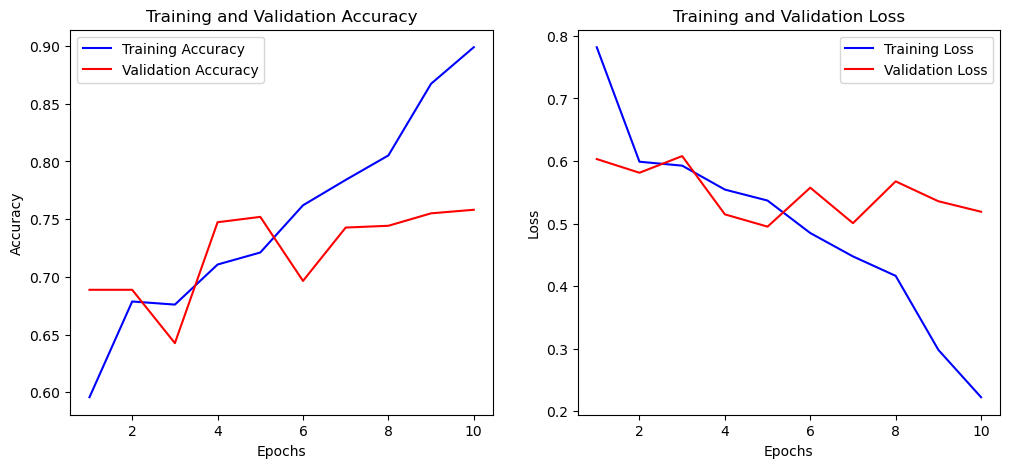

In [15]:
# Plot training history for VGG16-10-FT
plot_training_history(history_vgg16_10ft)

### EfficientNetV2B0 

In [40]:
# EfficientNetV2B0 Transfer Learning + Fine-Tuning
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

def to_effnet_inputs(x: np.ndarray) -> np.ndarray:
    x255 = (x * 255.0).astype("float32")
    return preprocess_input(x255)

X_train_eff = to_effnet_inputs(X_train)
X_val_eff   = to_effnet_inputs(X_val)

base = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base.layers:
    layer.trainable = True

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
z = base(inputs, training=True)
z = layers.GlobalAveragePooling2D()(z)
z = layers.Dropout(0.3)(z)
outputs = layers.Dense(1, activation='sigmoid')(z)

model_eff = Model(inputs, outputs)

model_eff.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name = 'auc')]
)

# Train VGG16-10-FT
reduce_lr_eff = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3,
    min_lr=1e-6 
)

# Define a callback
early_eff = EarlyStopping(monitor='val_loss', 
                       patience=5, restore_best_weights=True)

history_eff = model_eff.fit(
    X_train_eff, y_train,
    validation_data=(X_val_eff, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr_eff, early_eff]
)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5869 - auc: 0.5795 - loss: 0.6643 - precision: 0.4624 - recall: 0.3862 - val_accuracy: 0.6749 - val_auc: 0.7383 - val_loss: 0.5846 - val_precision: 0.6054 - val_recall: 0.5940 - learning_rate: 1.0000e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7499 - auc: 0.8253 - loss: 0.5214 - precision: 0.7039 - recall: 0.6285 - val_accuracy: 0.7165 - val_auc: 0.7924 - val_loss: 0.5362 - val_precision: 0.6723 - val_recall: 0.6015 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8297 - auc: 0.9095 - loss: 0.4116 - precision: 0.8307 - recall: 0.7454 - val_accuracy: 0.7288 - val_auc: 0.8052 - val_loss: 0.5261 - val_precision: 0.6758 - val_recall: 0.6504 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8857 - auc: 0.9493 - loss: 0.3143 - precision: 0.8794 - recall: 0.8329 - val_accuracy: 0.7365 - val_auc: 0.8177 - val_loss: 0.54

In [41]:
# Evaluate EffNet
loss, acc, precision, recall, auc = model_eff.evaluate(X_val_eff, y_val)
# Get AUC score
print(f"Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Get F1 score
y_pred_probs = model_eff.predict(X_val_eff)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Get the report as a dictionary
report = classification_report(y_val, y_pred_classes, output_dict=True)

# Convert to DataFrame and drop support column
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop('support', axis=1)

print(df_report)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.7118 - auc: 0.7950 - loss: 0.5343 - precision: 0.6630 - recall: 0.6051
Loss: 0.5261, Acc: 0.7288, Precision: 0.6758, Recall: 0.6504, AUC: 0.8052
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step
              precision    recall  f1-score
0              0.763359  0.783290  0.773196
1              0.675781  0.650376  0.662835
accuracy       0.728814  0.728814  0.728814
macro avg      0.719570  0.716833  0.718016
weighted avg   0.727464  0.728814  0.727963


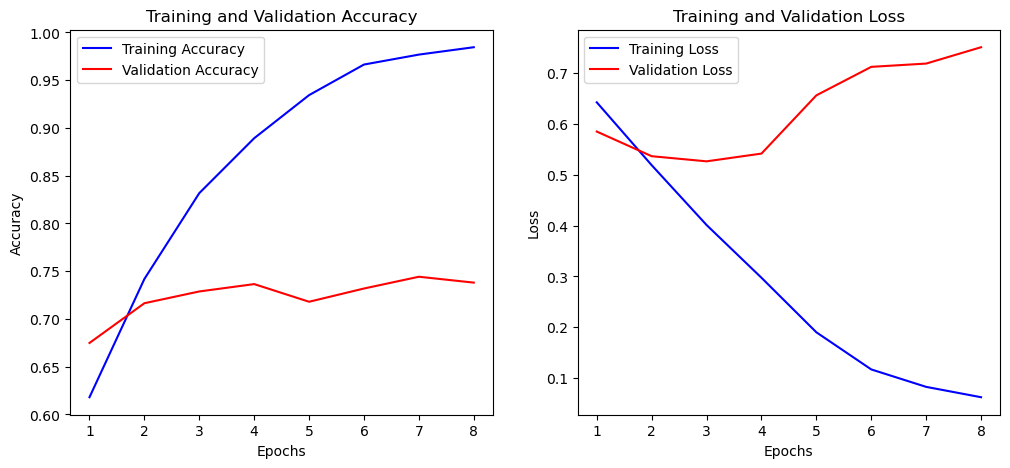

In [42]:
plot_training_history(history_eff)

### ResNet50

In [ ]:
# ResNet50 Transfer Learning + Fine-Tuning
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Preprocess for ResNet50
def to_resnet_inputs(x: np.ndarray) -> np.ndarray:
    x255 = (x * 255.0).astype("float32")
    return resnet_preprocess(x255)

X_train_res = to_resnet_inputs(X_train)
X_val_res   = to_resnet_inputs(X_val)

# Build ResNet50 base
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Classification head
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
z = resnet_base(inputs, training=False)
z = layers.GlobalAveragePooling2D()(z)
z = layers.Dropout(0.3)(z)
outputs = layers.Dense(1, activation='sigmoid')(z)

model_resnet50 = Model(inputs, outputs)

model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name = 'auc')]
)

# Callbacks
reduce_lr_res = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_res = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_resnet50 = model_resnet50.fit(
    X_train_res, y_train,
    validation_data=(X_val_res, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr_res, early_res]
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6200 - auc: 0.6528 - loss: 0.6727 - precision: 0.5400 - recall: 0.5149 - val_accuracy: 0.7057 - val_auc: 0.7725 - val_loss: 0.5572 - val_precision: 0.6482 - val_recall: 0.6165 - learning_rate: 1.0000e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9396 - auc: 0.9869 - loss: 0.2170 - precision: 0.9377 - recall: 0.9181 - val_accuracy: 0.6965 - val_auc: 0.8215 - val_loss: 0.7481 - val_precision: 0.8000 - val_recall: 0.3459 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9941 - auc: 0.9998 - loss: 0.0459 - precision: 0.9942 - recall: 0.9915 - val_accuracy: 0.7458 - val_auc: 0.8284 - val_loss: 0.7554 - val_precision: 0.6593 - val_recall: 0.7857 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0115 - precision: 0.9992 - recall: 1.0000 - val_accuracy: 0.7488 - val_auc: 0.8199 - val_loss: 0.7658 

In [38]:
# Evaluate ResNet50
loss, acc, precision, recall, auc = model_resnet50.evaluate(X_val_res, y_val)
# Get AUC score
print(f"Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Get F1 score
y_pred_probs = model_eff.predict(X_val_res)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Get the report as a dictionary
report = classification_report(y_val, y_pred_classes, output_dict=True)

# Convert to DataFrame and drop support column
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop('support', axis=1)

print(df_report)

21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 806ms/step - accuracy: 0.6906 - auc: 0.7404 - loss: 0.5831 - precision: 0.6273 - recall: 0.6115
Loss: 0.5572, Acc: 0.7057, Precision: 0.6482, Recall: 0.6165, AUC: 0.7725
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step
              precision    recall  f1-score
0              0.594684  0.934726  0.726904
1              0.468085  0.082707  0.140575
accuracy       0.585516  0.585516  0.585516
macro avg      0.531385  0.508716  0.433739
weighted avg   0.542796  0.585516  0.486590


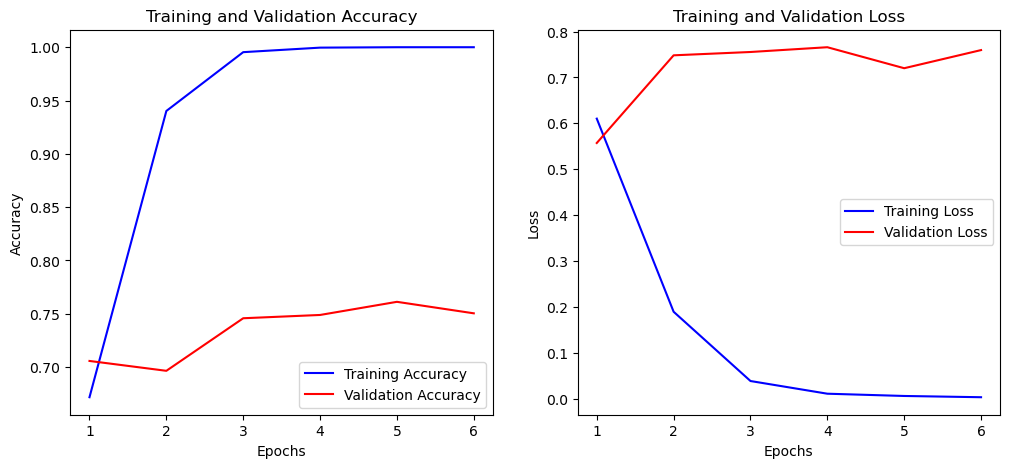

In [22]:
plot_training_history(history_resnet50)

### Feature extraction (VGG16, no fine tuning, for a comparative study)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model, Input

IMG_SIZE = 224

# Load pretrained VGG16 without the top classifier
vgg_base = VGG16(include_top=False, 
                 weights='imagenet',
                 input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all VGG layers
for layer in vgg_base.layers:
    layer.trainable = False

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

x = Sequential()
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)           # still apply augmentation
x = vgg_base(x, training=False)         # pass through VGG16 feature extractor


# Stage 1
x = layers.Conv2D(16, (3,3), strides=1, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)

# Stage 2
x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
# VGG has heavy pooling, with this I get negative dimension space
# x = layers.MaxPooling2D((2,2))(x)

# Stage 3
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
# x = layers.MaxPooling2D((2,2))(x)

# Stage 4: residual block (1x1 -> 3x3 -> 1x1)
res = layers.Conv2D(64, (1,1), padding="same", activation="relu")(x)
res = layers.Conv2D(64, (3,3), padding="same", activation="relu")(res)
res = layers.Conv2D(64, (1,1), padding="same", activation="relu")(res)
x = layers.Add()([x, res])

# Global Average Pooling + output
x = layers.GlobalAveragePooling2D()(x)

# Labels are already binary 
outputs = layers.Dense(1, activation="sigmoid")(x)


hybrid_model = Model(inputs, outputs)

hybrid_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer_19[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ augmentation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 16)  │     73,744 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 3, 3, 16)  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 3, 3, 32)  │      4,640 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 64)  │     18,496 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 64)  │      4,160 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 3, 64)  │     36,928 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3, 3, 64)  │      4,160 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3, 3, 64)  │          0 │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,856,881 (56.67 MB)

 Trainable params: 142,193 (555.44 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [46]:
from sklearn.metrics import roc_auc_score

hybrid_model.compile(optimizer="adam",
                     loss="binary_crossentropy",
                     metrics=["accuracy", "precision", "recall", tf.keras.metrics.AUC(name="auc")])


In [47]:
# Reduce Learning Rate
reduce_lr_hybrid = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3,
    min_lr=1e-6 
)

# Define a callback
early_hybrid = EarlyStopping(monitor='val_loss', 
                       patience=5, restore_best_weights=True)

history_hybrid_model = hybrid_model.fit(
    X_train_vgg, y_train,
    validation_data=(X_val_vgg, y_val),
    epochs=50,
    callbacks=[reduce_lr_vgg, early_vgg]
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5796 - auc: 0.5633 - loss: 0.6954 - precision: 0.4497 - recall: 0.3166 - val_accuracy: 0.6579 - val_auc: 0.7038 - val_loss: 0.6212 - val_precision: 0.5887 - val_recall: 0.5489 - learning_rate: 0.0010
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6602 - auc: 0.7033 - loss: 0.6022 - precision: 0.5947 - recall: 0.4241 - val_accuracy: 0.6733 - val_auc: 0.7246 - val_loss: 0.5929 - val_precision: 0.6154 - val_recall: 0.5414 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6683 - auc: 0.7331 - loss: 0.5862 - precision: 0.6261 - recall: 0.4632 - val_accuracy: 0.6841 - val_auc: 0.7226 - val_loss: 0.6706 - val_precision: 0.7798 - val_recall: 0.3195 - learning_rate: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6842 - auc: 0.7537 - loss: 0.5697 - precision: 0.6368 - recall: 0.5133 - val_accuracy: 0.6949 - val_auc: 0.7337 - val_loss: 0.5887 - val_pre

In [48]:
# Evaluate on validation set
loss, acc, precision, recall, auc = hybrid_model.evaluate(X_val_vgg, y_val)
print(f"Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Get F1 score
y_pred_probs = hybrid_model.predict(X_val_vgg)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Get the report as a dictionary
report = classification_report(y_val, y_pred_classes, output_dict=True)

# Convert to DataFrame and drop support column
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop('support', axis=1)

print(df_report)

21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6883 - auc: 0.7308 - loss: 0.5943 - precision: 0.6666 - recall: 0.4836
Loss: 0.5750, Acc: 0.7119, Precision: 0.7068, Recall: 0.5075, AUC: 0.7527
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
              precision    recall  f1-score
0              0.713974  0.853786  0.777646
1              0.706806  0.507519  0.590810
accuracy       0.711864  0.711864  0.711864
macro avg      0.710390  0.680652  0.684228
weighted avg   0.711036  0.711864  0.701069


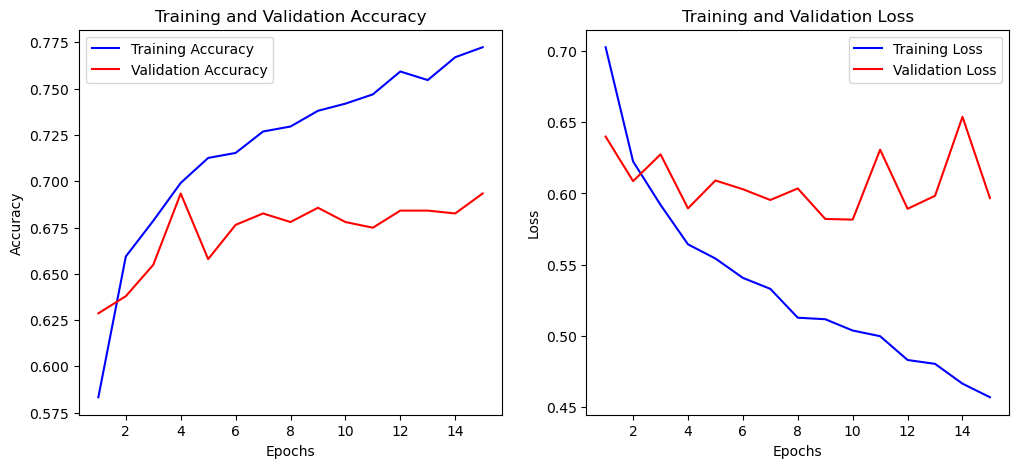

In [40]:
plot_training_history(history_hybrid_model)

#### RadImageNet Pretrained Weights instead of ImageNet

#### ResNet50

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Build ResNet50 backbone (without top FC layers)
base_model = ResNet50(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Load RadImageNet pretrained weights
base_model.load_weights("RadImageNet_Models/RadImageNet-ResNet50_notop.h5")

# Data is already normalised
X_train_rad_resnet50 = X_train
X_val_rad_resnet50   = X_val

# Add your classification head
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation="sigmoid")(x)

model_rad_resnet50 = Model(inputs, outputs)

model_rad_resnet50.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name = 'auc')]
)

# Callbacks
reduce_lr_rad_resnet50 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_rad_resnet50 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_rad_resnet50 = model_rad_resnet50.fit(
    X_train_rad_resnet50, y_train,
    validation_data=(X_val_rad_resnet50, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr_rad_resnet50, early_rad_resnet50]
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.5796 - auc: 0.5496 - loss: 0.6756 - precision: 0.4482 - recall: 0.1562 - val_accuracy: 0.6086 - val_auc: 0.6620 - val_loss: 0.6715 - val_precision: 0.5189 - val_recall: 0.6203 - learning_rate: 1.0000e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - accuracy: 0.6557 - auc: 0.7326 - loss: 0.6202 - precision: 0.6904 - recall: 0.2703 - val_accuracy: 0.6626 - val_auc: 0.7313 - val_loss: 0.6284 - val_precision: 0.5936 - val_recall: 0.5602 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.7075 - auc: 0.7932 - loss: 0.5676 - precision: 0.7349 - recall: 0.4754 - val_accuracy: 0.6672 - val_auc: 0.7433 - val_loss: 0.5855 - val_precision: 0.6471 - val_recall: 0.4135 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - accuracy: 0.8215 - auc: 0.8956 - loss: 0.4182 - precision: 0.8107 - recall: 0.7328 - val_accuracy: 0.6764 - val_auc: 0.7412 - val_loss: 0.66

In [ ]:
# Evaluate ResNet50
loss, acc, precision, recall, auc = model_rad_resnet50.evaluate(X_val_rad_resnet50, y_val)
# Get AUC score
print(f"Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Get F1 score
y_pred_probs = model_rad_resnet50.predict(X_val_rad_resnet50)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Get the report as a dictionary
report = classification_report(y_val, y_pred_classes, output_dict=True)

# Convert to DataFrame and drop support column
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop('support', axis=1)

print(df_report)

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 572ms/step - accuracy: 0.6472 - auc: 0.7226 - loss: 0.5993 - precision: 0.6175 - recall: 0.3680
Loss: 0.5855, Acc: 0.6672, Precision: 0.6471, Recall: 0.4135, AUC: 0.7433
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 610ms/step
              precision    recall  f1-score
0              0.674322  0.843342  0.749420
1              0.647059  0.413534  0.504587
accuracy       0.667180  0.667180  0.667180
macro avg      0.660690  0.628438  0.627004
weighted avg   0.663148  0.667180  0.649072


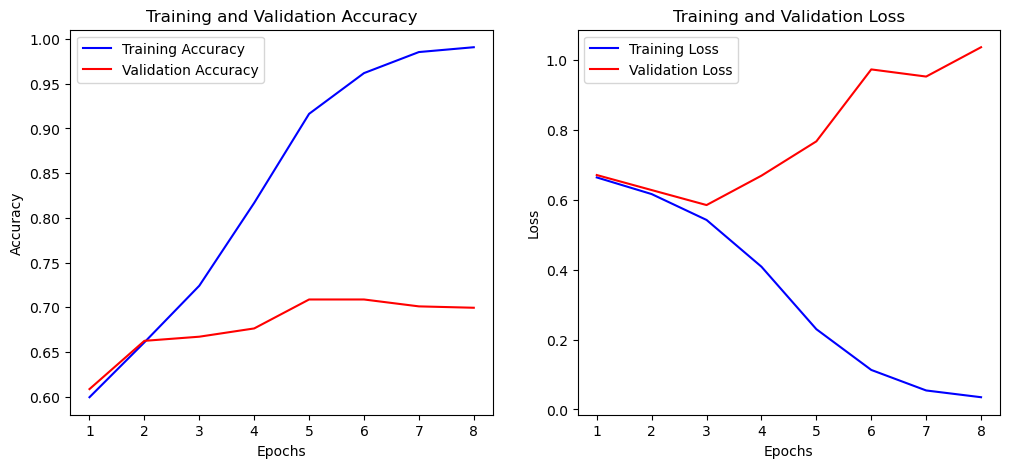

In [13]:
plot_training_history(history_rad_resnet50)

### DenseNet121

In [29]:
from tensorflow.keras.applications import DenseNet121

# Build DenseNet121 backbone (without top FC layers)
densenet_base_model = DenseNet121(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Load RadImageNet pretrained weights
densenet_base_model.load_weights("RadImageNet_Models/RadImageNet-DenseNet121_notop.h5")

# Normalising inputs
X_train_rad_densenet = X_train
X_val_rad_densenet = X_val

# Add your classification head
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = densenet_base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation="sigmoid")(x)

model_rad_densenet = Model(inputs, outputs)

model_rad_densenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name = 'auc')]
)

# Callbacks
reduce_lr_rad_densenet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_rad_densenet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_rad_densenet = model_rad_densenet.fit(
    X_train_rad_densenet, y_train,
    validation_data=(X_val_rad_densenet, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr_rad_densenet, early_rad_densenet]
)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.5901 - auc: 0.5778 - loss: 0.6641 - precision: 0.4401 - recall: 0.1041 - val_accuracy: 0.6364 - val_auc: 0.7195 - val_loss: 0.6572 - val_precision: 0.5412 - val_recall: 0.7406 - learning_rate: 1.0000e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.6947 - auc: 0.7623 - loss: 0.5897 - precision: 0.7159 - recall: 0.4357 - val_accuracy: 0.6857 - val_auc: 0.7460 - val_loss: 0.5991 - val_precision: 0.6649 - val_recall: 0.4699 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 384s 5s/step - accuracy: 0.7840 - auc: 0.8549 - loss: 0.5103 - precision: 0.7972 - recall: 0.6356 - val_accuracy: 0.6872 - val_auc: 0.7619 - val_loss: 0.5685 - val_precision: 0.6649 - val_recall: 0.4774 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 377s 5s/step - accuracy: 0.8311 - auc: 0.9213 - loss: 0.4201 - precision: 0.8420 - recall: 0.7424 - val_accuracy: 0.6733 - val_auc: 0.7688 - val_loss: 0.60

In [ ]:
# Evaluate ResNet50
loss, acc, precision, recall, auc = model_rad_densenet.evaluate(X_val_rad_densenet, y_val)
# Get AUC score
print(f"Loss: {loss:.4f}, Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Get F1 score
y_pred_probs = model_rad_resnet50.predict(X_val_rad_resnet50)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Get the report as a dictionary
report = classification_report(y_val, y_pred_classes, output_dict=True)

# Convert to DataFrame and drop support column
df_report = pd.DataFrame(report).transpose()
df_report = df_report.drop('support', axis=1)

print(df_report)

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 925ms/step - accuracy: 0.6619 - auc: 0.7362 - loss: 0.5852 - precision: 0.6239 - recall: 0.4474
Loss: 0.5685, Acc: 0.6872, Precision: 0.6649, Recall: 0.4774, AUC: 0.7619
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step
              precision    recall  f1-score
0              0.626072  0.953003  0.755694
1              0.727273  0.180451  0.289157
accuracy       0.636364  0.636364  0.636364
macro avg      0.676672  0.566727  0.522425
weighted avg   0.667550  0.636364  0.564478


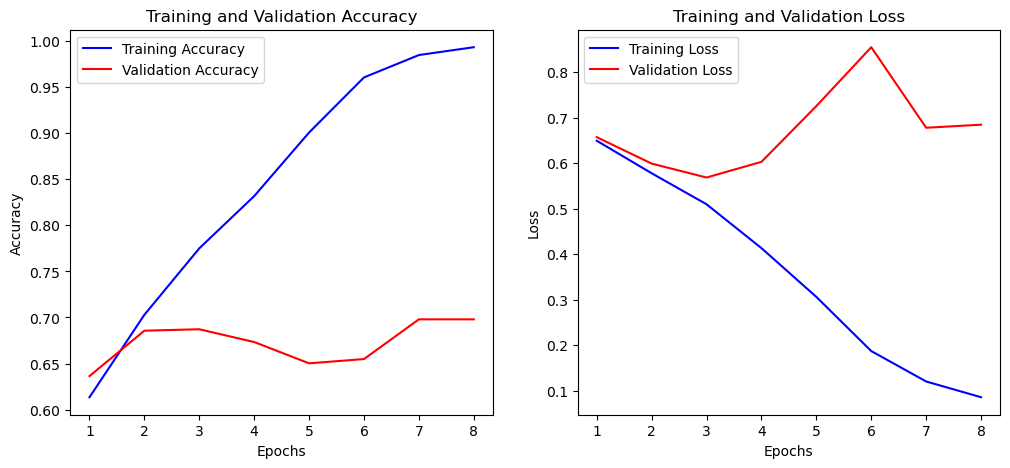

In [35]:
plot_training_history(history_rad_densenet)